In [74]:
import arviz as az
import jax.numpy as jnp
import numpyro
import matplotlib.pylab as plt
import numpyro.distributions as dist
from jax import random

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80

In [78]:
cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBC_z_0_4.cdf"
cdf_file_bigger_prior_delta = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBCO3_larger_prior_on_delta_mu.cdf"
# "./RUNS/CBC_O3_Peak.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))
data_big = az.from_netcdf(cdf_file_bigger_prior_delta)
samps_big = data.posterior.stack(draws=("chain", "draw"))

In [76]:
def sigmoid(low, delta, width, middle, zs):
    return delta / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

zs = np.linspace(0,2,500)

In [77]:
new_priors = {
    "logR20":dist.Uniform(-2,1),
    "alpha_ref":dist.Normal(-2,3),
    "mu_m1":dist.Uniform(20,50),
    "mMin":dist.Uniform(5,15),
    "bq":dist.Normal(0,3),
    "alpha_z":dist.Normal(0,4),
    "beta_z":dist.Uniform(0,10),
    "zp": dist.Uniform(0,4),
    "fpeak": dist.Uniform(-5,0),
    "log_high_f_peak": dist.Uniform(-5,0),
    "width_f_peak": dist.Uniform(-1,1),
    "middle_z_f_peak": dist.Uniform(0,4),
    "delta_mu": dist.Normal(0, 10),
    "width_mu": dist.Uniform(-1,1),
    "middle_z_mu": dist.Uniform(0,4),
    "sig_m1": dist.Uniform(1.5,15),
    "high_sig": dist.Uniform(1.5,15),
    "width_sig": dist.Uniform(-1,1),
    "middle_z_sig": dist.Uniform(0,4),
}

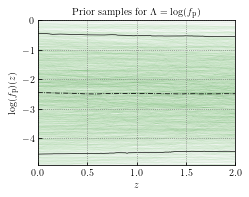

In [63]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_log_f_peak = rand.uniform(-5,0, samps.log_f_peak.size)
prior_high_f_peak = rand.uniform(-5,0, samps.log_f_peak.size)
prior_width_f_peak = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_f_peak = rand.uniform(0, 4, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_log_f_peak[i],
                               prior_high_f_peak[i],
                               10.**prior_width_f_peak[i],
                               prior_middle_f_peak[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-4.9, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_fp_median = median_fp
only_prior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Prior_trace_f_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

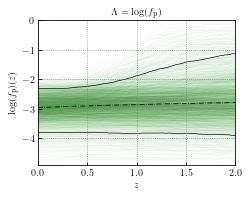

In [53]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-4.9, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Trace_f_peak_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

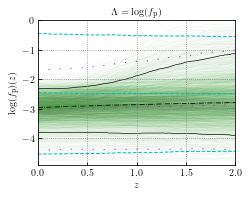

In [71]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-4.9, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_fp_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_fp_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_fp_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Trace_f_peak_peak_with_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

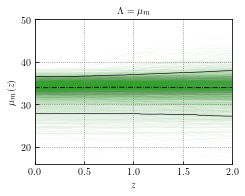

In [8]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid(samps.mu_m1.values[i],
                               samps.delta_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

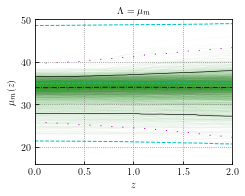

In [81]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid(samps.mu_m1.values[i],
                               samps.delta_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_mu_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

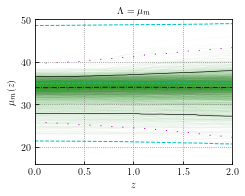

In [82]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
for i in range(samps_big.mu_m1.size):
    mu_r = sigmoid(samps_big.mu_m1.values[i],
                               samps_big.delta_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_mu_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_prior_and_prior_plus_posterior_big_prior_delta_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()

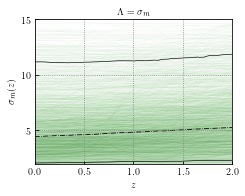

In [9]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(2.01,15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r'$\Lambda = \sigma_{m}$', fontsize = 10)
plt.savefig("Trace_sigma_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

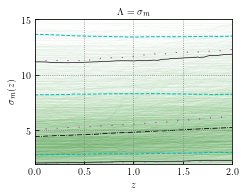

In [73]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(2.01,15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_sigma_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r'$\Lambda = \sigma_{m}$', fontsize = 10)
plt.savefig("Trace_sigma_peak_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

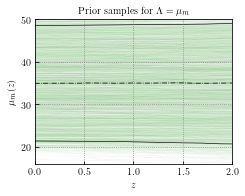

In [79]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_mu = rand.uniform(20, 50, samps.log_f_peak.size)
prior_delta_mu = rand.normal(0, 5, samps.log_f_peak.size)
prior_width_mu = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_mu = rand.uniform(0, 4, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid(prior_mu[i],
                               prior_delta_mu[i],
                               10.**prior_width_mu[i],
                               prior_middle_mu[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_mu_median = median_fp
only_prior_mu_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_mu_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \mu_m$", fontsize = 10)
plt.savefig("Prior_trace_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()

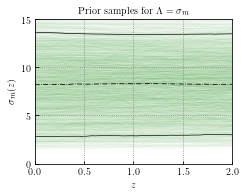

In [66]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_high_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_width_sigma = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_sigma = rand.uniform(0, 4, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_sigma[i],
                               prior_high_sigma[i],
                               10.**prior_width_sigma[i],
                               prior_middle_sigma[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(0, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_sigma_median = median_fp
only_prior_sigma_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_sigma_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \sigma_m$", fontsize = 10)
plt.savefig("Prior_trace_sigma.pdf", dpi=400, bbox_inches='tight')
plt.show()

Now what if we take the lowest value of the posterior and then use a random prior value.

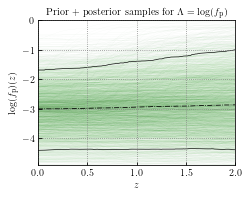

In [67]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

posterior_low_f_peak = samps.log_f_peak.values

for i in range(samps.log_f_peak.size):
    prior_sample_high_f_peak = rand.uniform(-5,0)
    prior_sample_width_f_peak = rand.uniform(-1,1)
    prior_sample_middle_f_peak = rand.uniform(0,4)
    f_peak_r = sigmoid_no_delta(posterior_low_f_peak[i],
                               prior_sample_high_f_peak,
                               10.**prior_sample_width_f_peak,
                               prior_sample_middle_f_peak,
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-4.9, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
prior_posterior_fp_median = median_fp
prior_posterior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_f_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

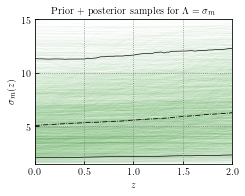

In [68]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))

posterior_low_sigma = samps_big.sig_m1.values

for i in range(samps_big.log_f_peak.size):
    prior_sample_high_sig = rand.uniform(1.5,15)
    prior_sample_width_sig = rand.uniform(-1,1)
    prior_sample_middle_sig = rand.uniform(0,4)
    f_peak_r = sigmoid_no_delta(posterior_low_sigma[i],
                               prior_sample_high_sig,
                               10.**prior_sample_width_sig,
                               prior_sample_middle_sig,
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(1.5, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
prior_posterior_sigma_median = median_fp
prior_posterior_sigma_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_sigma_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \sigma_m$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_sigma.pdf", dpi=400, bbox_inches='tight')
plt.show()

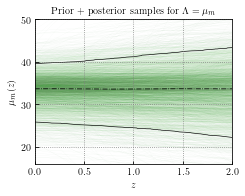

In [80]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))

posterior_low_mu = samps_big.mu_m1.values

for i in range(samps_big.log_f_peak.size):
    prior_sample_delta_mu = rand.normal(0,10)
    prior_sample_width_mu = rand.uniform(-1,1)
    prior_sample_middle_mu = rand.uniform(0,4)
    f_peak_r = sigmoid(posterior_low_mu[i],
                               prior_sample_delta_mu,
                               10.**prior_sample_width_mu,
                               prior_sample_middle_mu,
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
prior_posterior_mu_median = median_fp
prior_posterior_mu_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_mu_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \mu_m$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()